In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from collections import Counter

%matplotlib inline

In [2]:
import sklearn.metrics
import sklearn.cross_validation
import sklearn.tree
import sklearn.decomposition
import sklearn.preprocessing
import sklearn.grid_search



In [92]:
import itertools

In [3]:
sl_train = pd.read_csv('train.csv')


//anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (8,9,10,11,12,43,157,196,214,225,228,229,231,235,238) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


##Columns (8,9,10,11,12,43,157,196,214,225,228,229,231,235,238) have mixed types.

In [4]:
m,n = sl_train.shape
print m, n

145231 1934


In [5]:
random.seed(1)
r = np.random.choice(m, size = 10000, replace=False)

In [6]:
sl_train.columns

Index([u'ID', u'VAR_0001', u'VAR_0002', u'VAR_0003', u'VAR_0004', u'VAR_0005',
       u'VAR_0006', u'VAR_0007', u'VAR_0008', u'VAR_0009', 
       ...
       u'VAR_1926', u'VAR_1927', u'VAR_1928', u'VAR_1929', u'VAR_1930',
       u'VAR_1931', u'VAR_1932', u'VAR_1933', u'VAR_1934', u'target'],
      dtype='object', length=1934)

In [41]:
mixed_objects = [8,9,10,11,12,43,157,196,214,225,228,229,231,235,238] #all classified as objects
print len(mixed_objects)

15


In [42]:
#checking mixed type columns
for i in mixed_objects:
    s = set(sl_train.iloc[r,i].values)
    if len(s) < 80:
        print i, sl_train.columns[i], s

8 VAR_0008 set([False, nan])
9 VAR_0009 set([False, nan])
10 VAR_0010 set([False, nan])
11 VAR_0011 set([False, nan])
12 VAR_0012 set([False, nan])
43 VAR_0043 set([False, nan])
196 VAR_0196 set([False, nan])
225 VAR_0226 set([False, True, nan])
228 VAR_0229 set([False, nan])
229 VAR_0230 set([False, True, nan])
231 VAR_0232 set([False, True, nan])
235 VAR_0236 set([False, True, nan])
238 VAR_0239 set([False, nan])


In [51]:
#checking mixed type columns
remove_vars = []
objects = []
for i in mixed_objects:
    if len(set(sl_train.iloc[r,i].values)) == 1 or len(set(sl_train.iloc[r,i].values)) > 10:
        remove_vars.append(sl_train.columns[i])
    else:
        objects.append(sl_train.columns[i])

In [52]:
print len(remove_vars)
remove_vars

2


['VAR_0157', 'VAR_0214']

Var 157 and 214 are NaN and Misc Dates


In [53]:
Counter(sl_train.iloc[:,225])

Counter({False: 144703, True: 472, nan: 56})

In [54]:
id_num = ['ID']
target = ['target']
ints = []
floats = []


In [55]:
#Categorizing Variable Types
for col in sl_train:
    if col == 'ID' or col == 'target' or col in objects:
        continue
    elif sl_train[col].dtype == 'int64':
        s = set(sl_train[col])
        if len(s) == 1:
            remove_vars.append(col)
        else:
            ints.append((col, len(s), s))
    elif sl_train[col].dtype == 'float64':
        floats.append(col)
    elif sl_train[col].dtype == 'object':
        objects.append(col)
        

In [66]:
print len(ints) + len(floats) + len(objects)

1930


In [19]:
n_categories_ints = map(lambda x: x[1] if x[1] < 60 else -1, ints)

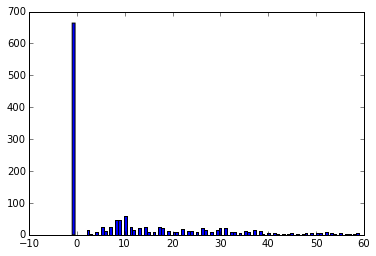

In [20]:
plt.hist(n_categories_ints, bins = 100)
plt.show()

In [21]:
ints.sort(key = lambda x: x[1])

In [22]:
len(ints)

1402

In [24]:
len(set(sl_train[ints[1000][0]]))

237

In [25]:
Counter(sl_train[ints[1000][0]])

Counter({-99999: 103440, 0: 8802, 100: 855, 92: 498, 93: 496, 97: 495, 96: 493, 91: 472, 95: 469, 94: 455, 98: 451, 90: 450, 89: 422, 87: 416, 85: 401, 88: 396, 82: 386, 86: 377, 2: 376, 80: 375, 99: 370, 81: 357, 83: 351, 84: 342, 74: 336, 1: 334, 75: 333, 78: 333, 79: 323, 3: 322, 71: 321, 77: 318, 4: 317, 5: 314, 10: 311, 69: 310, 72: 308, 11: 305, 63: 305, 76: 305, 73: 302, 66: 300, 7: 297, 70: 295, 49: 292, 21: 291, 9: 290, 12: 290, 13: 290, 8: 288, 51: 288, 60: 288, 15: 286, 61: 285, 65: 284, 67: 284, 6: 282, 56: 282, 26: 281, 41: 281, 16: 279, 19: 279, 40: 279, 23: 278, 68: 278, 33: 277, 64: 277, 27: 276, 47: 276, 48: 276, 14: 275, 46: 274, 35: 271, 22: 267, 50: 267, 62: 266, 36: 265, 44: 265, 45: 265, 58: 264, 59: 263, 39: 262, 32: 261, 55: 261, 17: 260, 31: 260, 53: 259, 54: 257, 57: 257, 18: 254, 24: 254, 37: 251, 28: 248, 38: 246, 43: 246, 34: 245, 20: 243, 25: 241, 29: 239, 42: 235, 52: 235, 101: 218, 30: 217, 102: 158, 103: 119, 104: 94, 107: 68, 105: 65, 106: 57, 110: 48,

In [26]:
Counter(sl_train[ints[700][0]])

Counter({3: 17589, 2: 17469, 4: 16199, 1: 14625, 5: 14266, 6: 12064, 7: 10427, 8: 8433, 9: 7003, 10: 5576, 11: 4473, 12: 3609, 13: 2831, 14: 2273, 15: 1730, 16: 1350, 17: 1075, 18: 882, 19: 614, 99: 601, 20: 471, 21: 367, 22: 281, 23: 224, 24: 168, 25: 149, 26: 92, 27: 88, 28: 68, 29: 41, 30: 30, 31: 29, 32: 27, 33: 19, 34: 17, 35: 14, 36: 9, 37: 9, 39: 9, 41: 7, 38: 4, 51: 4, 40: 3, 47: 3, 44: 2, 46: 2, 42: 1, 50: 1, 52: 1, 60: 1, 69: 1})

In [70]:
#look at different types of int variables and splits them into categories
ints_categories_binary = []
ints_categories_55 = []
ints_real = []

for var, l, s in ints:
    if l == 2:
        ints_categories_binary.append(var)
    elif l <= 55:
        ints_categories_55.append(var)
    else:
        ints_real.append(var)

In [71]:
print len(ints)
print len(ints_categories_binary) + len(ints_categories_55) + len(ints_real)

1402
1402


In [ ]:
# Need to cooerce non 0/1 binaries into 0/1 binaries

In [ ]:
#Need to generate dummy variables on category binaries ?? Combine rare events using counter?

def simplify_column(col):
    '''
    Removes uncommon events from pandas column
    '''
    
    

In [31]:
#for cols in ints_categories_55:
#    print Counter(sl_train[cols])

Counter({0: 140366, 1: 4715, 9: 150})
Counter({0: 138276, 1: 6354, 99: 601})
Counter({0: 132944, 1: 11686, 99: 601})
Counter({-99999: 131353, 0: 11265, 1: 2560, 2: 53})
Counter({0: 143396, 1: 1177, 99: 601, 2: 57})
Counter({0: 144449, 99: 601, 1: 175, 2: 6})
Counter({0: 144393, 99: 601, 1: 225, 2: 12})
Counter({0: 135438, 1: 9163, 2: 587, 3: 43})
Counter({0: 127972, 1: 17166, 2: 92, 3: 1})
Counter({0: 144252, 99: 601, 1: 359, 2: 19})
Counter({998: 143814, 1: 739, 999: 601, 400: 77})
Counter({98: 131582, 0: 12683, 99: 601, 1: 352, 2: 13})
Counter({98: 131582, 97: 8396, 0: 4583, 99: 601, 1: 69})
Counter({98: 131582, 97: 8396, 0: 4607, 99: 601, 1: 45})
Counter({-99999: 109735, 0: 33149, 1: 2284, 2: 61, 3: 2})
Counter({-99999: 131353, 0: 7440, 1: 6168, 2: 265, 3: 5})
Counter({-99999: 131353, 0: 9514, 1: 4238, 2: 125, 3: 1})
Counter({0: 142443, 1: 2085, 99: 601, 2: 98, 3: 4})
Counter({0: 141946, 1: 2554, 99: 601, 2: 121, 3: 9})
Counter({0: 142769, 1: 1774, 99: 601, 2: 84, 3: 3})
Counter({0:

In [73]:
len(remove_vars)

4

In [74]:
len(remove_vars)

4

In [75]:
#Crashes Notebook
object_categories_50 = []
object_other = []

for cols in objects:
    if len(set(sl_train.loc[r,cols].values)) == 1:
        remove_vars.append(cols)        
    elif len(set(sl_train.loc[r,cols].values)) <= 55:
        object_categories_50.append(cols)
    else:
        object_other.append(cols)
        

Floats #OK
Ints Binary #OK
Ints Categorical
Ints Real #OK
Objects Categorical
Objects Other 

In [79]:
print len(floats) + len(ints_categories_binary) + len(ints_categories_55) \
    + len(ints_real) + len(object_categories_50) + len(object_other)

1930


In [72]:
for cols in ints_categories_binary:
    print cols, Counter(sl_train[cols])

VAR_0563 Counter({0: 140501, 1: 4730})
VAR_0566 Counter({0: 121232, 1: 23999})
VAR_0567 Counter({0: 143064, 1: 2167})
VAR_0732 Counter({-99999: 74801, 0: 70430})
VAR_0733 Counter({0: 110393, -99999: 34838})
VAR_0736 Counter({0: 92376, -99999: 52855})
VAR_0737 Counter({-99999: 81544, 0: 63687})
VAR_0739 Counter({0: 112352, -99999: 32879})
VAR_0740 Counter({0: 118217, 1: 27014})
VAR_0741 Counter({0: 141328, 1: 3903})
VAR_0924 Counter({0: 144760, 1: 471})
VAR_1162 Counter({0: 119058, 1: 26173})
VAR_1163 Counter({0: 120946, 1: 24285})
VAR_1164 Counter({0: 144409, 1: 822})
VAR_1165 Counter({0: 144165, 1: 1066})
VAR_1427 Counter({0: 145145, 1: 86})


In [89]:
for cols in ints_categories_binary:
    if set(sl_train[cols]) != set([0,1]):
        print cols
        sl_train[cols] = sl_train[cols].apply(lambda x: 0 if x == 0 else 1)

VAR_0732
VAR_0733
VAR_0736
VAR_0737
VAR_0739


In [90]:
for cols in ints_categories_binary:
    print cols, Counter(sl_train[cols])

VAR_0563 Counter({0: 140501, 1: 4730})
VAR_0566 Counter({0: 121232, 1: 23999})
VAR_0567 Counter({0: 143064, 1: 2167})
VAR_0732 Counter({1: 74801, 0: 70430})
VAR_0733 Counter({0: 110393, 1: 34838})
VAR_0736 Counter({0: 92376, 1: 52855})
VAR_0737 Counter({1: 81544, 0: 63687})
VAR_0739 Counter({0: 112352, 1: 32879})
VAR_0740 Counter({0: 118217, 1: 27014})
VAR_0741 Counter({0: 141328, 1: 3903})
VAR_0924 Counter({0: 144760, 1: 471})
VAR_1162 Counter({0: 119058, 1: 26173})
VAR_1163 Counter({0: 120946, 1: 24285})
VAR_1164 Counter({0: 144409, 1: 822})
VAR_1165 Counter({0: 144165, 1: 1066})
VAR_1427 Counter({0: 145145, 1: 86})


In [96]:
objects_binary = []
objects_category = []
for cols in object_categories_50:
    print cols, Counter(sl_train[cols])
    if len(set(sl_train[cols])) == 2:
        objects_binary.append(cols)
    else:
        objects_category.append(cols)

VAR_0008 Counter({False: 145175, nan: 56})
VAR_0009 Counter({False: 145175, nan: 56})
VAR_0010 Counter({False: 145175, nan: 56})
VAR_0011 Counter({False: 145175, nan: 56})
VAR_0012 Counter({False: 145175, nan: 56})
VAR_0043 Counter({False: 145175, nan: 56})
VAR_0196 Counter({False: 145175, nan: 56})
VAR_0226 Counter({False: 144703, True: 472, nan: 56})
VAR_0229 Counter({False: 145175, nan: 56})
VAR_0230 Counter({False: 145004, True: 171, nan: 56})
VAR_0232 Counter({True: 82118, False: 63057, nan: 56})
VAR_0236 Counter({True: 144849, False: 326, nan: 56})
VAR_0239 Counter({False: 145175, nan: 56})
VAR_0001 Counter({'R': 84893, 'H': 59829, 'Q': 509})
VAR_0005 Counter({'B': 71449, 'C': 54299, 'N': 16605, 'S': 2878})
VAR_0044 Counter({'[]': 145175, nan: 56})
VAR_0202 Counter({'BatchInquiry': 145175, nan: 56})
VAR_0216 Counter({'DS': 145175, nan: 56})
VAR_0222 Counter({'C6': 145175, nan: 56})
VAR_0237 Counter({'CA': 15770, 'TX': 14186, 'NC': 11691, 'GA': 8730, 'IL': 8479, 'VA': 8081, 'OH': 

In [98]:
x = False
print 0 if x is False else 1

0


In [99]:
for cols in objects_binary:
    sl_train[cols] = sl_train[cols].apply(lambda x: 0 if x is False else 1)

In [101]:
for cols in objects_binary:
    print cols, Counter(sl_train[cols])

 VAR_0008 Counter({0: 145175, 1: 56})
VAR_0009 Counter({0: 145175, 1: 56})
VAR_0010 Counter({0: 145175, 1: 56})
VAR_0011 Counter({0: 145175, 1: 56})
VAR_0012 Counter({0: 145175, 1: 56})
VAR_0043 Counter({0: 145175, 1: 56})
VAR_0196 Counter({0: 145175, 1: 56})
VAR_0229 Counter({0: 145175, 1: 56})
VAR_0239 Counter({0: 145175, 1: 56})
VAR_0044 Counter({1: 145231})
VAR_0202 Counter({1: 145231})
VAR_0216 Counter({1: 145231})
VAR_0222 Counter({1: 145231})


In [102]:
# Use jaccard similarity score and itertools combination to see which columns are similar
for col1, col2 in itertools.combinations(objects_binary, 2):
    print col1, col2, sklearn.metrics.jaccard_similarity_score(sl_train[col1], sl_train[col2])

VAR_0008 VAR_0009 1.0
VAR_0008 VAR_0010 1.0
VAR_0008 VAR_0011 1.0
VAR_0008 VAR_0012 1.0
VAR_0008 VAR_0043 1.0
VAR_0008 VAR_0196 1.0
VAR_0008 VAR_0229 1.0
VAR_0008 VAR_0239 1.0
VAR_0008 VAR_0044 0.000385592607639
VAR_0008 VAR_0202 0.000385592607639
VAR_0008 VAR_0216 0.000385592607639
VAR_0008 VAR_0222 0.000385592607639
VAR_0009 VAR_0010 1.0
VAR_0009 VAR_0011 1.0
VAR_0009 VAR_0012 1.0
VAR_0009 VAR_0043 1.0
VAR_0009 VAR_0196 1.0
VAR_0009 VAR_0229 1.0
VAR_0009 VAR_0239 1.0
VAR_0009 VAR_0044 0.000385592607639
VAR_0009 VAR_0202 0.000385592607639
VAR_0009 VAR_0216 0.000385592607639
VAR_0009 VAR_0222 0.000385592607639
VAR_0010 VAR_0011 1.0
VAR_0010 VAR_0012 1.0
VAR_0010 VAR_0043 1.0
VAR_0010 VAR_0196 1.0
VAR_0010 VAR_0229 1.0
VAR_0010 VAR_0239 1.0
VAR_0010 VAR_0044 0.000385592607639
VAR_0010 VAR_0202 0.000385592607639
VAR_0010 VAR_0216 0.000385592607639
VAR_0010 VAR_0222 0.000385592607639
VAR_0011 VAR_0012 1.0
VAR_0011 VAR_0043 1.0
VAR_0011 VAR_0196 1.0
VAR_0011 VAR_0229 1.0
VAR_0011 VAR_0239 

In [73]:
#Generate Dummies for categorical variables

In [104]:
to_dummies = objects_category + ints_categories_55

In [106]:
len(to_dummies)

725

In [107]:
list_of_dummy_dfs = [pd.get_dummies(sl_train[cols], prefix=cols) for cols in to_dummies]

In [108]:
test = pd.concat(list_of_dummy_dfs, axis = 1)

In [109]:
test.shape

(145231, 15166)

In [ ]:
sl_train.drop(axis = 1, inplace = True)

In [74]:
scaler = sklearn.preprocessing.StandardScaler()
pca = sklearn.decomposition.PCA()
clf = sklearn.tree.DecisionTreeClassifier()
grid = sklearn.grid_search.GridSearchCV()

TypeError: __init__() takes at least 3 arguments (1 given)

In [75]:
# params = {}

In [76]:
len(objects)

51

In [77]:
len(object_categories_50)

39

In [78]:
for cols in object_other:
    print sl_train.loc[1:50,cols].values

['04SEP12:00:00:00' nan nan nan nan nan nan '26JAN12:00:00:00' nan
 '18SEP12:00:00:00' nan '14APR12:00:00:00' nan nan nan nan nan
 '25OCT11:00:00:00' nan nan nan nan nan nan nan nan '22NOV11:00:00:00'
 '19JAN12:00:00:00' nan nan nan nan nan '19JAN12:00:00:00' nan nan nan
 '30NOV11:00:00:00' '17FEB12:00:00:00' nan '30OCT11:00:00:00' nan nan
 '16APR08:00:00:00' '31MAR12:00:00:00' '16APR12:00:00:00' nan nan
 '05MAY11:00:00:00' nan]
['10NOV11:00:00:00' '13DEC11:00:00:00' '23SEP10:00:00:00'
 '15OCT11:00:00:00' '06JUN12:00:00:00' '26NOV10:00:00:00'
 '18JAN12:00:00:00' '26JAN12:00:00:00' '28JUL12:00:00:00'
 '03AUG10:00:00:00' '18NOV11:00:00:00' '06FEB08:00:00:00'
 '15DEC11:00:00:00' '03MAY12:00:00:00' '24JAN12:00:00:00'
 '20SEP12:00:00:00' '19SEP12:00:00:00' '07APR10:00:00:00'
 '06SEP12:00:00:00' '05JUN12:00:00:00' '26JUL12:00:00:00'
 '12SEP12:00:00:00' '25FEB12:00:00:00' '28APR12:00:00:00'
 '15AUG12:00:00:00' '13DEC11:00:00:00' '17SEP10:00:00:00'
 '26JUL07:00:00:00' '18MAY12:00:00:00' '23OCT

In [112]:
cat_dummies = pd.DataFrame()
for cols in object_categories_50[:5]:
    cat_dummies = pd.concat([cat_dummies, pd.get_dummies(sl_train[cols], prefix=cols)], axis = 1)

In [94]:
#For generating train/test, concatonate the two tables and remove the identifier before training.
#Remove unneccessary or difficult to work with variables.

In [115]:
#test = pd.get_dummies(sl_train[cols], prefix=cols)

In [104]:
#cols = object_categories_50[1]

In [105]:
#test = pd.get_dummies(sl_train[cols], prefix=cols)

In [114]:
#pd.concat([cat_dummies, test])